# HW06: Деревья решений и ансамбли

**Датасет:** S06-hw-dataset-01.csv (бинарная классификация, умеренный дисбаланс)

---

## Содержание

1. Загрузка данных и первичный анализ
2. Train/Test-сплит и воспроизводимость
3. Baseline модели
4. Модели недели 6
5. Метрики качества
6. Интерпретация лучшей модели
7. Опциональные задания
8. Сохранение артефактов

---

<a id='1'></a>
## 1. Загрузка данных и первичный анализ


In [1]:
# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc,
    classification_report, ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

# Модели
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)

# Настройки
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Настройки визуализации
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("✓ Все библиотеки загружены")


✓ Все библиотеки загружены


In [2]:
# Загрузка данных
data_path = 'S06-hw-dataset-01.csv'
df = pd.read_csv(data_path)

print(f"Размер датасета: {df.shape}")
print(f"\nПервые строки:")
df.head()


Размер датасета: (12000, 30)

Первые строки:


,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,1,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,...,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33,0
1,2,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,...,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102,1
2,3,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,...,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3,0
3,4,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,...,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50,0
4,5,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,...,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81,0


In [3]:
# Базовая информация
print("=== Информация о датасете ===")
df.info()


=== Информация о датасете ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             12000 non-null  int64  
 1   num01          12000 non-null  float64
 2   num02          12000 non-null  float64
 3   num03          12000 non-null  float64
 4   num04          12000 non-null  float64
 5   num05          12000 non-null  float64
 6   num06          12000 non-null  float64
 7   num07          12000 non-null  float64
 8   num08          12000 non-null  float64
 9   num09          12000 non-null  float64
 10  num10          12000 non-null  float64
 11  num11          12000 non-null  float64
 12  num12          12000 non-null  float64
 13  num13          12000 non-null  float64
 14  num14          12000 non-null  float64
 15  num15          12000 non-null  float64
 16  num16          12000 non-null  float64
 17  num17          12000

In [4]:
# Статистики
print("\n=== Описательные статистики ===")
df.describe()



=== Описательные статистики ===


,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.013705,-0.005278,-0.002357,0.038404,-0.006301,-0.865297,-0.702877,-0.290694,-0.008154,...,-0.323083,-1.314833,0.319798,-0.002742,0.027459,0.988750,1.990167,1.506833,36.083833,0.323417
std,3464.24595,2.096534,3.544498,1.004417,2.087318,1.007329,3.888966,1.989513,3.455981,0.996677,...,2.167066,3.731384,2.223649,0.996454,1.882359,0.815687,1.411643,1.121558,25.061218,0.467800
min,1.00000,-8.155181,-14.605579,-4.374043,-7.753301,-3.999332,-15.238402,-7.377252,-13.853627,-3.794637,...,-8.371050,-14.249204,-8.638879,-3.532093,-7.923990,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,-1.423844,-2.303772,-0.685618,-1.374579,-0.676552,-3.532054,-2.064888,-2.597019,-0.683959,...,-1.808969,-3.863063,-1.097700,-0.676150,-1.110822,0.000000,1.000000,0.000000,17.000000,0.000000
50%,6000.50000,-0.047565,0.053348,-0.009186,0.038766,-0.003728,-1.092517,-0.795907,-0.208245,-0.020883,...,-0.383940,-1.393400,0.431804,0.006297,0.279689,1.000000,2.000000,2.000000,30.000000,0.000000
75%,9000.25000,1.422676,2.335937,0.671441,1.484417,0.669269,1.526389,0.522625,2.093169,0.666959,...,1.125140,1.116111,1.853491,0.657478,1.363896,2.000000,3.000000,3.000000,49.000000,1.000000
max,12000.00000,8.610863,16.299709,3.651692,7.571965,4.562115,16.223054,8.006444,13.030011,3.976868,...,7.957847,15.937281,8.102095,3.707905,7.549514,2.000000,4.000000,3.000000,120.000000,1.000000


In [5]:
# Проверка пропусков
print("\n=== Проверка пропусков ===")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✓ Пропусков нет")
else:
    print(missing[missing > 0])



=== Проверка пропусков ===
✓ Пропусков нет



=== Распределение таргета ===
target
0    8119
1    3881
Name: count, dtype: int64

Баланс классов:
target
0    0.676583
1    0.323417
Name: proportion, dtype: float64


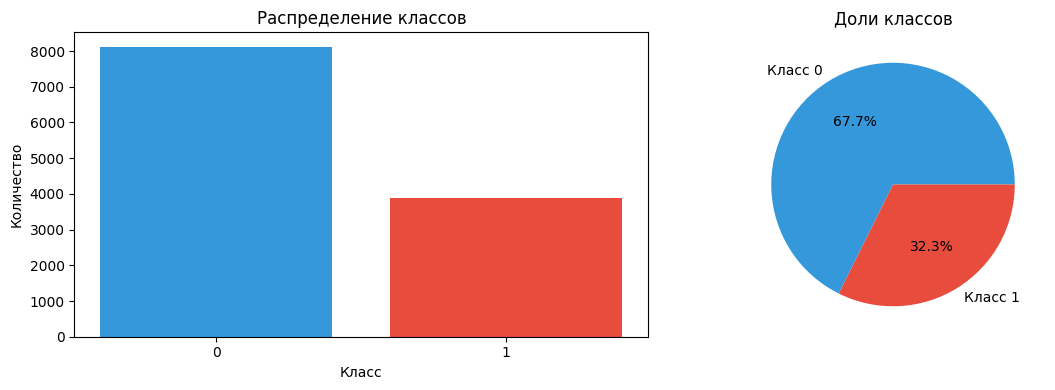

✓ График сохранен: artifacts/figures/target_distribution.png


In [7]:
# Распределение таргета
print("\n=== Распределение таргета ===")
target_counts = df['target'].value_counts()
print(target_counts)
print(f"\nБаланс классов:")
print(df['target'].value_counts(normalize=True))

# Визуализация
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].bar(target_counts.index, target_counts.values, color=['#3498db', '#e74c3c'])
ax[0].set_xlabel('Класс')
ax[0].set_ylabel('Количество')
ax[0].set_title('Распределение классов')
ax[0].set_xticks([0, 1])

ax[1].pie(target_counts.values, labels=['Класс 0', 'Класс 1'],
          autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
ax[1].set_title('Доли классов')

plt.tight_layout()
plt.savefig('artifacts/figures/target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ График сохранен: artifacts/figures/target_distribution.png")


<a id='2'></a>
## 2. Train/Test-сплит и воспроизводимость

Фиксируем `random_state=42` и используем `stratify=y` для сохранения баланса классов.


In [8]:
# Определение признаков и таргета
# Исключаем 'id' (если есть) и 'target'
X = df.drop(columns=['target'])
if 'id' in X.columns:
    X = X.drop(columns=['id'])
    print("✓ Колонка 'id' исключена из признаков")

y = df['target']

print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")
print(f"\nПризнаки: {list(X.columns)}")


✓ Колонка 'id' исключена из признаков
Размер X: (12000, 28)
Размер y: (12000,)

Признаки: ['num01', 'num02', 'num03', 'num04', 'num05', 'num06', 'num07', 'num08', 'num09', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'num24', 'cat_contract', 'cat_region', 'cat_payment', 'tenure_months']


In [9]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")
print(f"\nРаспределение в train: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Распределение в test: {y_test.value_counts(normalize=True).to_dict()}")
print("\n✓ Стратификация сохранила баланс классов")


Train size: (9000, 28)
Test size: (3000, 28)

Распределение в train: {0: 0.6765555555555556, 1: 0.3234444444444444}
Распределение в test: {0: 0.6766666666666666, 1: 0.3233333333333333}

✓ Стратификация сохранила баланс классов


**Почему это важно:**
- **random_state** обеспечивает воспроизводимость результатов
- **stratify** сохраняет пропорции классов в train и test
- Это критично для корректной оценки моделей, особенно при дисбалансе


<a id='3'></a>
## 3. Baseline модели

Начнем с простых baseline-моделей для сравнения.


In [11]:
def print_metrics(y_true, y_pred, y_proba=None, model_name="Model"):
    """Вывод основных метрик"""
    print(f"\n{'='*50}")
    print(f"{model_name}")
    print(f"{'='*50}")

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")

    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        print(f"ROC-AUC:  {roc_auc:.4f}")

    print(f"\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    return {"accuracy": acc, "f1": f1, "roc_auc": roc_auc if y_proba is not None else None}

# Словарь для сохранения метрик
results = {}


In [13]:
# Baseline 1: DummyClassifier (most_frequent) - самая простая baseline модель
# Эта модель всегда предсказывает наиболее часто встречающийся класс
# Используется для понимания минимально возможного качества
# Любая разумная модель должна превосходить DummyClassifier

dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)

# Получаем предсказания на тестовой выборке
y_pred_dummy = dummy.predict(X_test)

# Выводим метрики и сохраняем их в словарь результатов
metrics_dummy = print_metrics(y_test, y_pred_dummy, model_name="Baseline: DummyClassifier")
results['DummyClassifier'] = metrics_dummy



Baseline: DummyClassifier
Accuracy: 0.6767
F1-score: 0.0000

Confusion Matrix:
[[2030    0]
 [ 970    0]]


**Почему DummyClassifier важен:**
- Показывает baseline, который получается "без обучения"
- При дисбалансе классов может давать высокий accuracy (но низкий F1)
- Помогает понять, действительно ли модель что-то выучила

In [14]:
# Baseline 2: LogisticRegression с нормализацией
# Логистическая регрессия - классический линейный метод для бинарной классификации
# Используем Pipeline для последовательного применения нормализации и модели
# StandardScaler нормализует признаки (mean=0, std=1), что важно для логрегрессии

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Шаг 1: Нормализация признаков
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))  # Шаг 2: Обучение модели
])

# Обучаем Pipeline (нормализация + логрегрессия)
lr_pipeline.fit(X_train, y_train)

# Получаем предсказания (классы)
y_pred_lr = lr_pipeline.predict(X_test)

# Получаем вероятности принадлежности к классу 1 (нужны для ROC-AUC)
# [:, 1] берет второй столбец - вероятности класса 1
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Выводим метрики с учетом вероятностей (включая ROC-AUC)
metrics_lr = print_metrics(y_test, y_pred_lr, y_proba_lr, model_name="Baseline: LogisticRegression")
results['LogisticRegression'] = metrics_lr



Baseline: LogisticRegression
Accuracy: 0.8297
F1-score: 0.7147
ROC-AUC:  0.8789

Confusion Matrix:
[[1849  181]
 [ 330  640]]


**Почему LogisticRegression важна:**
- Простая и интерпретируемая модель
- Быстро обучается и предсказывает
- Служит "разумным" baseline для сравнения с более сложными моделями
- Если дерево/ансамбль не превосходит логрегрессию, возможно, данные линейно разделимы


<a id='4'></a>
## 4. Модели недели 6

Обучим и настроим основные модели на основе деревьев решений:
1. **DecisionTreeClassifier** - одно дерево с контролем сложности
2. **RandomForestClassifier** - ансамбль деревьев (bagging)
3. **GradientBoostingClassifier** - последовательный ансамбль (boosting)


In [15]:
print("=== DecisionTreeClassifier ===\n")

# ШАГ 1: Сначала обучим полное дерево БЕЗ регуляризации
# Это покажет, насколько дерево склонно к переобучению
# Полное дерево растет до тех пор, пока в листьях не останется только один класс

tree_full = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_full.fit(X_train, y_train)

print("Полное дерево (без регуляризации):")
print(f"Глубина дерева: {tree_full.get_depth()}")
print(f"Количество листьев: {tree_full.get_n_leaves()}")

# Получаем предсказания и вероятности
y_pred_tree_full = tree_full.predict(X_test)
y_proba_tree_full = tree_full.predict_proba(X_test)[:, 1]

# Выводим метрики полного дерева
metrics_tree_full = print_metrics(y_test, y_pred_tree_full, y_proba_tree_full,
                                   model_name="DecisionTree (full)")

# Сравним качество на train и test для выявления переобучения
y_pred_train_full = tree_full.predict(X_train)
y_proba_train_full = tree_full.predict_proba(X_train)[:, 1]
train_acc_full = accuracy_score(y_train, y_pred_train_full)
train_roc_full = roc_auc_score(y_train, y_proba_train_full)

print(f"\n--- Проверка переобучения ---")
print(f"Train Accuracy: {train_acc_full:.4f} | Test Accuracy: {metrics_tree_full['accuracy']:.4f}")
print(f"Train ROC-AUC:  {train_roc_full:.4f} | Test ROC-AUC:  {metrics_tree_full['roc_auc']:.4f}")
print(f"Разница (переобучение): Accuracy: {train_acc_full - metrics_tree_full['accuracy']:.4f}, "
      f"ROC-AUC: {train_roc_full - metrics_tree_full['roc_auc']:.4f}")


=== DecisionTreeClassifier ===

Полное дерево (без регуляризации):
Глубина дерева: 24
Количество листьев: 641

DecisionTree (full)
Accuracy: 0.8567
F1-score: 0.7767
ROC-AUC:  0.8343

Confusion Matrix:
[[1822  208]
 [ 222  748]]

--- Проверка переобучения ---
Train Accuracy: 1.0000 | Test Accuracy: 0.8567
Train ROC-AUC:  1.0000 | Test ROC-AUC:  0.8343
Разница (переобучение): Accuracy: 0.1433, ROC-AUC: 0.1657


**Ожидаемый результат:**
- На train полное дерево показывает ~100% accuracy (идеально запоминает данные)
- На test качество значительно хуже - это явный признак переобучения
- Поэтому необходим контроль сложности через гиперпараметры


In [16]:
# ШАГ 2: Подбор гиперпараметров через GridSearchCV
# Будем настраивать параметры, контролирующие сложность дерева:
# - max_depth: максимальная глубина дерева (чем меньше, тем проще дерево)
# - min_samples_leaf: минимальное количество объектов в листе (защита от мелких листьев)
# - min_samples_split: минимальное количество объектов для разбиения узла

print("\n--- Подбор гиперпараметров через GridSearchCV ---")

# Сетка гиперпараметров для перебора
param_grid_tree = {
    'max_depth': [3, 5, 7, 10, 15],           # Глубина дерева
    'min_samples_leaf': [5, 10, 20, 30],      # Минимум объектов в листе
    'min_samples_split': [10, 20, 30]         # Минимум объектов для split'а
}

# GridSearchCV перебирает все комбинации параметров и выбирает лучшую
# cv=5 означает 5-fold кросс-валидацию (train делится на 5 частей)
# scoring='roc_auc' - метрика для выбора лучших параметров
# n_jobs=-1 - использовать все доступные ядра процессора

grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid_tree,
    cv=5,                    # 5-fold кросс-валидация
    scoring='roc_auc',       # Оптимизируем ROC-AUC
    n_jobs=-1,               # Параллельное выполнение
    verbose=1                # Показывать прогресс
)

# Обучаем GridSearch (это займет время, т.к. перебирается много комбинаций)
print(f"Всего комбинаций для перебора: {len(param_grid_tree['max_depth']) * len(param_grid_tree['min_samples_leaf']) * len(param_grid_tree['min_samples_split'])}")
grid_tree.fit(X_train, y_train)

# Выводим лучшие найденные параметры
print(f"\n✓ Подбор завершен!")
print(f"Лучшие параметры: {grid_tree.best_params_}")
print(f"Лучший CV ROC-AUC: {grid_tree.best_score_:.4f}")

# Получаем лучшую модель и оцениваем ее на test
tree_best = grid_tree.best_estimator_
print(f"\nХарактеристики лучшего дерева:")
print(f"Глубина: {tree_best.get_depth()}")
print(f"Количество листьев: {tree_best.get_n_leaves()}")

# Предсказания на test
y_pred_tree = tree_best.predict(X_test)
y_proba_tree = tree_best.predict_proba(X_test)[:, 1]

# Выводим финальные метрики настроенного дерева
metrics_tree = print_metrics(y_test, y_pred_tree, y_proba_tree,
                              model_name="DecisionTree (tuned)")
results['DecisionTree'] = metrics_tree

# Проверяем переобучение для настроенного дерева
y_pred_train_tuned = tree_best.predict(X_train)
y_proba_train_tuned = tree_best.predict_proba(X_train)[:, 1]
train_acc_tuned = accuracy_score(y_train, y_pred_train_tuned)
train_roc_tuned = roc_auc_score(y_train, y_proba_train_tuned)

print(f"\n--- Сравнение с train (проверка переобучения) ---")
print(f"Train Accuracy: {train_acc_tuned:.4f} | Test Accuracy: {metrics_tree['accuracy']:.4f}")
print(f"Train ROC-AUC:  {train_roc_tuned:.4f} | Test ROC-AUC:  {metrics_tree['roc_auc']:.4f}")
print(f"Разница: Accuracy: {train_acc_tuned - metrics_tree['accuracy']:.4f}, "
      f"ROC-AUC: {train_roc_tuned - metrics_tree['roc_auc']:.4f}")

# Сохраняем результаты поиска для artifacts
tree_search_summary = {
    'best_params': grid_tree.best_params_,
    'best_cv_score': float(grid_tree.best_score_),
    'test_metrics': metrics_tree,
    'tree_depth': int(tree_best.get_depth()),
    'n_leaves': int(tree_best.get_n_leaves())
}



--- Подбор гиперпараметров через GridSearchCV ---
Всего комбинаций для перебора: 60
Fitting 5 folds for each of 60 candidates, totalling 300 fits

✓ Подбор завершен!
Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 30, 'min_samples_split': 10}
Лучший CV ROC-AUC: 0.9164

Характеристики лучшего дерева:
Глубина: 15
Количество листьев: 166

DecisionTree (tuned)
Accuracy: 0.8660
F1-score: 0.7928
ROC-AUC:  0.9164

Confusion Matrix:
[[1829  201]
 [ 201  769]]

--- Сравнение с train (проверка переобучения) ---
Train Accuracy: 0.8990 | Test Accuracy: 0.8660
Train ROC-AUC:  0.9638 | Test ROC-AUC:  0.9164
Разница: Accuracy: 0.0330, ROC-AUC: 0.0474


**Выводы по DecisionTree:**
- Полное дерево сильно переобучается (отличная работа на train, плохая на test)
- Регуляризация через max_depth и min_samples_leaf существенно улучшает обобщающую способность
- Настроенное дерево имеет гораздо меньший разрыв между train и test


In [17]:
print("\n=== RandomForestClassifier ===\n")

# Random Forest - это ансамбль из множества деревьев решений
# Основные идеи:
# 1. Bagging: каждое дерево обучается на случайной подвыборке данных (bootstrap)
# 2. Random subspace: каждое дерево видит только случайное подмножество признаков
# 3. Финальное предсказание = голосование/усреднение предсказаний всех деревьев
#
# Преимущества:
# - Снижает variance (переобучение) по сравнению с одним деревом
# - Более стабилен к выбросам и шуму
# - Хорошо работает "из коробки" без тонкой настройки

# Подбор гиперпараметров для Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],           # Количество деревьев в лесу
    'max_depth': [10, 15, 20, None],          # Глубина каждого дерева (None = без ограничений)
    'min_samples_leaf': [5, 10, 20],          # Минимум объектов в листе
    'max_features': ['sqrt', 'log2']          # Количество признаков для split'а
}

# max_features - ключевой параметр для Random Forest:
# - 'sqrt': sqrt(n_features) - обычно хорошо работает для классификации
# - 'log2': log2(n_features) - еще более случайный выбор признаков

print(f"Всего комбинаций для перебора: {len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['min_samples_leaf']) * len(param_grid_rf['max_features'])}")
print("Это может занять несколько минут...\n")

grid_rf = GridSearchCV(
    RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,              # Параллельное обучение деревьев
        warm_start=False        # Каждый fit начинается заново
    ),
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,                  # Параллельный перебор параметров
    verbose=1
)

# Запускаем поиск
grid_rf.fit(X_train, y_train)

# Выводим результаты
print(f"\n✓ Подбор завершен!")
print(f"Лучшие параметры: {grid_rf.best_params_}")
print(f"Лучший CV ROC-AUC: {grid_rf.best_score_:.4f}")

# Оценка на test
rf_best = grid_rf.best_estimator_
y_pred_rf = rf_best.predict(X_test)
y_proba_rf = rf_best.predict_proba(X_test)[:, 1]

metrics_rf = print_metrics(y_test, y_pred_rf, y_proba_rf,
                            model_name="RandomForest (tuned)")
results['RandomForest'] = metrics_rf

# Проверяем переобучение
y_pred_train_rf = rf_best.predict(X_train)
y_proba_train_rf = rf_best.predict_proba(X_train)[:, 1]
train_acc_rf = accuracy_score(y_train, y_pred_train_rf)
train_roc_rf = roc_auc_score(y_train, y_proba_train_rf)

print(f"\n--- Сравнение с train ---")
print(f"Train Accuracy: {train_acc_rf:.4f} | Test Accuracy: {metrics_rf['accuracy']:.4f}")
print(f"Train ROC-AUC:  {train_roc_rf:.4f} | Test ROC-AUC:  {metrics_rf['roc_auc']:.4f}")
print(f"Разница: Accuracy: {train_acc_rf - metrics_rf['accuracy']:.4f}, "
      f"ROC-AUC: {train_roc_rf - metrics_rf['roc_auc']:.4f}")

# Сохраняем результаты поиска
rf_search_summary = {
    'best_params': grid_rf.best_params_,
    'best_cv_score': float(grid_rf.best_score_),
    'test_metrics': metrics_rf,
    'n_trees': int(grid_rf.best_params_['n_estimators'])
}

print(f"\n✓ Random Forest с {rf_best.n_estimators} деревьями обучен")



=== RandomForestClassifier ===

Всего комбинаций для перебора: 72
Это может занять несколько минут...

Fitting 5 folds for each of 72 candidates, totalling 360 fits

✓ Подбор завершен!
Лучшие параметры: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}
Лучший CV ROC-AUC: 0.9663

RandomForest (tuned)
Accuracy: 0.9277
F1-score: 0.8819
ROC-AUC:  0.9677

Confusion Matrix:
[[1973   57]
 [ 160  810]]

--- Сравнение с train ---
Train Accuracy: 0.9756 | Test Accuracy: 0.9277
Train ROC-AUC:  0.9977 | Test ROC-AUC:  0.9677
Разница: Accuracy: 0.0479, ROC-AUC: 0.0300

✓ Random Forest с 200 деревьями обучен


**Выводы по RandomForest:**
- Random Forest обычно показывает лучшее качество, чем одно дерево
- Меньше переобучается благодаря ансамблированию
- n_estimators (количество деревьев) - важный параметр: больше деревьев = стабильнее, но медленнее
- max_features контролирует случайность: меньше признаков = более разнообразные деревья


In [18]:
print("\n=== GradientBoostingClassifier ===\n")

# Gradient Boosting - это последовательный ансамбль деревьев
# Основные идеи:
# 1. Деревья обучаются последовательно (одно за другим)
# 2. Каждое новое дерево исправляет ошибки предыдущих
# 3. Финальное предсказание = взвешенная сумма предсказаний всех деревьев
#
# Отличия от Random Forest:
# - RF: деревья независимы (параллельное обучение) - снижает variance
# - GB: деревья зависимы (последовательное обучение) - снижает bias
#
# Преимущества:
# - Часто дает лучшее качество, чем Random Forest
# - Хорошо работает на структурированных данных
# - Можно контролировать скорость обучения (learning_rate)

# Подбор гиперпараметров для Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 150],           # Количество деревьев (итераций boosting'а)
    'learning_rate': [0.01, 0.05, 0.1],       # Скорость обучения (вклад каждого дерева)
    'max_depth': [3, 5, 7],                   # Глубина деревьев (обычно неглубокие)
    'min_samples_leaf': [5, 10, 20]           # Минимум объектов в листе
}

# Важные параметры:
# - learning_rate: чем меньше, тем медленнее обучение, но часто лучше качество
#   Обычно используют малые значения (0.01-0.1) + много деревьев
# - n_estimators: количество итераций boosting'а
#   Больше деревьев = дольше обучение, но возможно лучше качество
# - max_depth: для boosting обычно используют мелкие деревья (3-7)

print(f"Всего комбинаций для перебора: {len(param_grid_gb['n_estimators']) * len(param_grid_gb['learning_rate']) * len(param_grid_gb['max_depth']) * len(param_grid_gb['min_samples_leaf'])}")
print("Gradient Boosting обучается медленнее Random Forest, это может занять время...\n")

grid_gb = GridSearchCV(
    GradientBoostingClassifier(
        random_state=RANDOM_STATE,
        subsample=0.8,          # Используем 80% данных для каждого дерева (stochastic GB)
        verbose=0
    ),
    param_grid_gb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,                  # Параллельный перебор параметров
    verbose=1
)

# Запускаем поиск
grid_gb.fit(X_train, y_train)

# Выводим результаты
print(f"\n✓ Подбор завершен!")
print(f"Лучшие параметры: {grid_gb.best_params_}")
print(f"Лучший CV ROC-AUC: {grid_gb.best_score_:.4f}")

# Оценка на test
gb_best = grid_gb.best_estimator_
y_pred_gb = gb_best.predict(X_test)
y_proba_gb = gb_best.predict_proba(X_test)[:, 1]

metrics_gb = print_metrics(y_test, y_pred_gb, y_proba_gb,
                            model_name="GradientBoosting (tuned)")
results['GradientBoosting'] = metrics_gb

# Проверяем переобучение
y_pred_train_gb = gb_best.predict(X_train)
y_proba_train_gb = gb_best.predict_proba(X_train)[:, 1]
train_acc_gb = accuracy_score(y_train, y_pred_train_gb)
train_roc_gb = roc_auc_score(y_train, y_proba_train_gb)

print(f"\n--- Сравнение с train ---")
print(f"Train Accuracy: {train_acc_gb:.4f} | Test Accuracy: {metrics_gb['accuracy']:.4f}")
print(f"Train ROC-AUC:  {train_roc_gb:.4f} | Test ROC-AUC:  {metrics_gb['roc_auc']:.4f}")
print(f"Разница: Accuracy: {train_acc_gb - metrics_gb['accuracy']:.4f}, "
      f"ROC-AUC: {train_roc_gb - metrics_gb['roc_auc']:.4f}")

# Сохраняем результаты поиска
gb_search_summary = {
    'best_params': grid_gb.best_params_,
    'best_cv_score': float(grid_gb.best_score_),
    'test_metrics': metrics_gb,
    'n_estimators': int(grid_gb.best_params_['n_estimators']),
    'learning_rate': float(grid_gb.best_params_['learning_rate'])
}

print(f"\n✓ Gradient Boosting с {gb_best.n_estimators} деревьями обучен")
print(f"  Learning rate: {gb_best.learning_rate}")



=== GradientBoostingClassifier ===

Всего комбинаций для перебора: 81
Gradient Boosting обучается медленнее Random Forest, это может занять время...

Fitting 5 folds for each of 81 candidates, totalling 405 fits

✓ Подбор завершен!
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 10, 'n_estimators': 150}
Лучший CV ROC-AUC: 0.9727

GradientBoosting (tuned)
Accuracy: 0.9407
F1-score: 0.9052
ROC-AUC:  0.9746

Confusion Matrix:
[[1972   58]
 [ 120  850]]

--- Сравнение с train ---
Train Accuracy: 1.0000 | Test Accuracy: 0.9407
Train ROC-AUC:  1.0000 | Test ROC-AUC:  0.9746
Разница: Accuracy: 0.0593, ROC-AUC: 0.0254

✓ Gradient Boosting с 150 деревьями обучен
  Learning rate: 0.1


**Выводы по GradientBoosting:**
- Boosting последовательно исправляет ошибки, часто достигая высокого качества
- learning_rate и n_estimators связаны: меньше lr → нужно больше деревьев
- Более склонен к переобучению, чем Random Forest (нужна аккуратная настройка)
- Обучается дольше из-за последовательности


<a id='5'></a>
## 5. Метрики качества и сравнение моделей

Теперь сравним все обученные модели по ключевым метрикам.


In [21]:
# ===================================================================
# СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
# ===================================================================
# Создаем DataFrame из словаря с результатами всех моделей
# Это позволит удобно сравнить модели по всем метрикам

results_df = pd.DataFrame(results).T  # Транспонируем для удобства
results_df = results_df.round(4)      # Округляем до 4 знаков

print("\n" + "="*70)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ (сортировка по ROC-AUC)")
print("="*70)
# Сортируем по ROC-AUC (обычно главная метрика для бинарной классификации)
print(results_df.sort_values('roc_auc', ascending=False))

# Выделяем лучшую модель
best_model_name = results_df['roc_auc'].idxmax()
best_model_score = results_df.loc[best_model_name, 'roc_auc']

print(f"\n{'='*70}")
print(f"   ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"   ROC-AUC на test: {best_model_score:.4f}")
print(f"   Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")
print(f"   F1-score: {results_df.loc[best_model_name, 'f1']:.4f}")
print(f"{'='*70}\n")



СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ (сортировка по ROC-AUC)
                    accuracy      f1  roc_auc
GradientBoosting      0.9407  0.9052   0.9746
RandomForest          0.9277  0.8819   0.9677
DecisionTree          0.8660  0.7928   0.9164
LogisticRegression    0.8297  0.7147   0.8789
DummyClassifier       0.6767  0.0000      NaN

   ЛУЧШАЯ МОДЕЛЬ: GradientBoosting
   ROC-AUC на test: 0.9746
   Accuracy: 0.9407
   F1-score: 0.9052



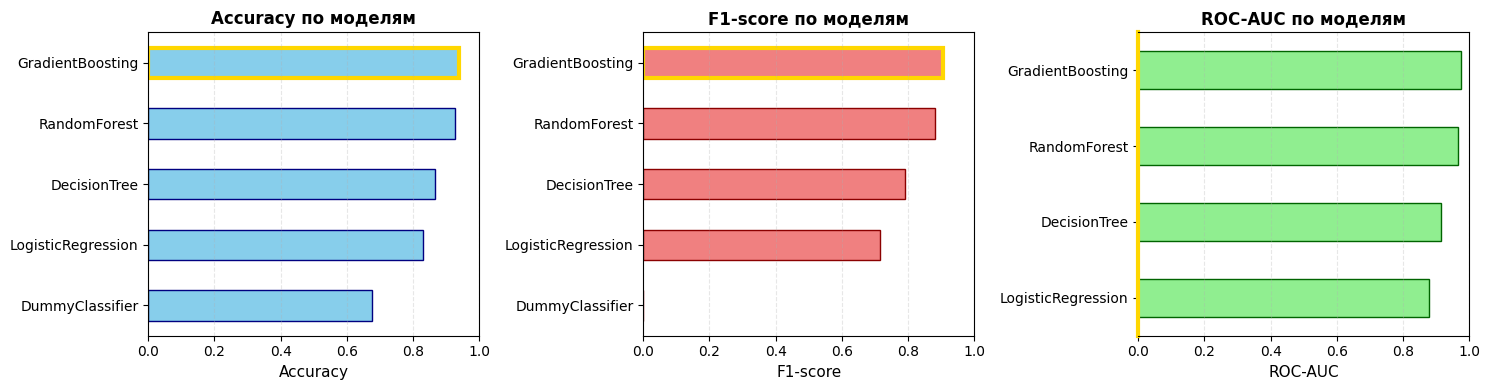

✓ График сохранен: artifacts/figures/models_comparison.png


In [22]:
# ===================================================================
# ВИЗУАЛИЗАЦИЯ: Сравнение по трем метрикам
# ===================================================================
# Создаем три графика рядом для наглядного сравнения моделей

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# График 1: Accuracy
# Горизонтальные столбцы (barh) удобны, когда много моделей
results_df['accuracy'].plot(kind='barh', ax=axes[0], color='skyblue', edgecolor='navy')
axes[0].set_xlabel('Accuracy', fontsize=11)
axes[0].set_title('Accuracy по моделям', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3, linestyle='--')
axes[0].set_xlim([0, 1])  # Accuracy всегда от 0 до 1

# График 2: F1-score
results_df['f1'].plot(kind='barh', ax=axes[1], color='lightcoral', edgecolor='darkred')
axes[1].set_xlabel('F1-score', fontsize=11)
axes[1].set_title('F1-score по моделям', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3, linestyle='--')
axes[1].set_xlim([0, 1])

# График 3: ROC-AUC
# Убираем NaN (если есть) - для DummyClassifier может не быть ROC-AUC
results_df['roc_auc'].dropna().plot(kind='barh', ax=axes[2], color='lightgreen', edgecolor='darkgreen')
axes[2].set_xlabel('ROC-AUC', fontsize=11)
axes[2].set_title('ROC-AUC по моделям', fontsize=12, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3, linestyle='--')
axes[2].set_xlim([0, 1])

# Подсвечиваем лучшую модель
for ax in axes:
    # Получаем позицию лучшей модели в списке
    model_names = list(results_df.index)
    if best_model_name in model_names:
        best_idx = model_names.index(best_model_name)
        # Подсвечиваем желтой рамкой
        ax.get_children()[best_idx].set_edgecolor('gold')
        ax.get_children()[best_idx].set_linewidth(3)

plt.tight_layout()
plt.savefig('artifacts/figures/models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ График сохранен: artifacts/figures/models_comparison.png")


**Интерпретация метрик:**
- **Accuracy** - доля правильных предсказаний (может вводить в заблуждение при дисбалансе)
- **F1-score** - гармоническое среднее precision и recall (учитывает оба класса)
- **ROC-AUC** - площадь под ROC-кривой (качество ранжирования, устойчива к дисбалансу)

Для задач с дисбалансом классов ROC-AUC и F1 более информативны, чем Accuracy.


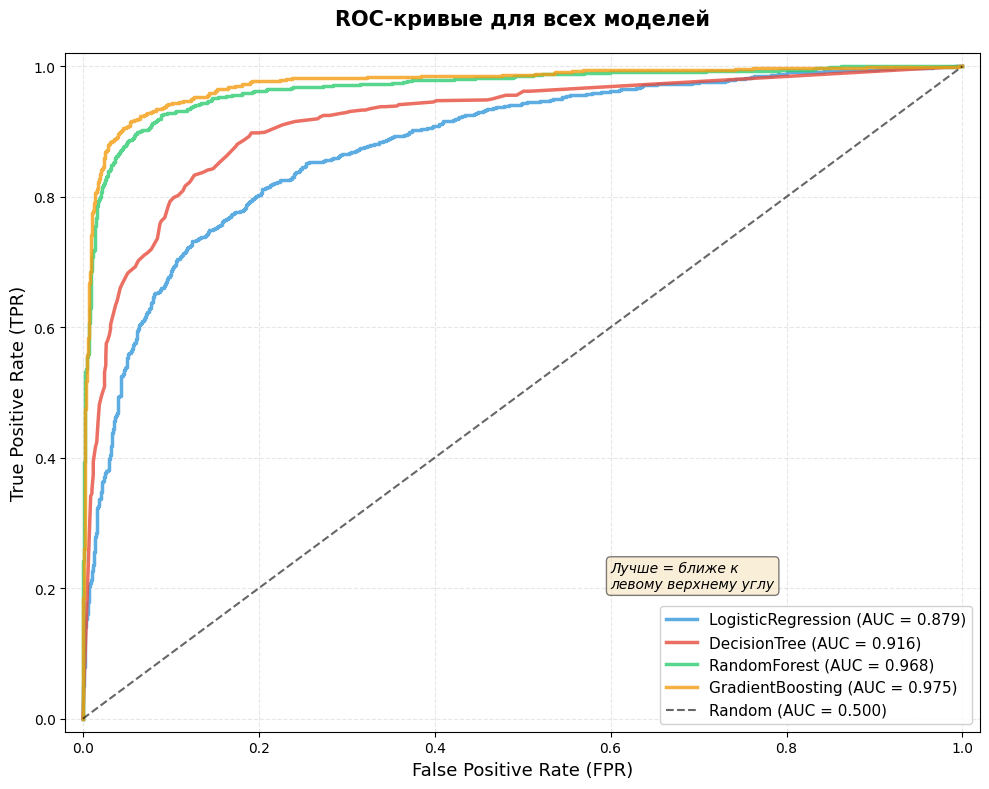

✓ График сохранен: artifacts/figures/roc_curves.png


In [23]:
# ===================================================================
# ROC-КРИВЫЕ для всех моделей
# ===================================================================
# ROC-кривая показывает соотношение TPR (True Positive Rate) и FPR (False Positive Rate)
# при разных порогах классификации
# Чем ближе кривая к левому верхнему углу, тем лучше модель
# ROC-AUC = площадь под кривой (1.0 = идеал, 0.5 = случайное угадывание)

fig, ax = plt.subplots(figsize=(10, 8))

# Словарь с вероятностями для всех моделей
models_proba = {
    'LogisticRegression': y_proba_lr,
    'DecisionTree': y_proba_tree,
    'RandomForest': y_proba_rf,
    'GradientBoosting': y_proba_gb
}

# Цвета для разных моделей
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

# Строим ROC-кривую для каждой модели
for (name, y_proba), color in zip(models_proba.items(), colors):
    # Вычисляем FPR, TPR для разных порогов
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    # Вычисляем площадь под кривой
    roc_auc = auc(fpr, tpr)
    # Рисуем кривую
    ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})',
            linewidth=2.5, color=color, alpha=0.8)

# Диагональ = случайный классификатор (ROC-AUC = 0.5)
ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1.5, alpha=0.6)

# Настройки графика
ax.set_xlabel('False Positive Rate (FPR)', fontsize=13)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=13)
ax.set_title('ROC-кривые для всех моделей', fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

# Добавляем аннотацию с пояснением
ax.text(0.6, 0.2, 'Лучше = ближе к\nлевому верхнему углу',
        fontsize=10, style='italic', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('artifacts/figures/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ График сохранен: artifacts/figures/roc_curves.png")


**Анализ ROC-кривых:**
- Модели, чьи кривые выше и левее, лучше разделяют классы
- ROC-AUC = 0.5 (диагональ) означает случайное угадывание
- ROC-AUC > 0.8 обычно считается хорошим результатом
- ROC-AUC > 0.9 - отличный результат


In [24]:
# ===================================================================
# Определяем лучшую модель для дальнейшего анализа
# ===================================================================

# Получаем лучшую обученную модель из словаря
best_models_dict = {
    'DecisionTree': tree_best,
    'RandomForest': rf_best,
    'GradientBoosting': gb_best,
    'LogisticRegression': lr_pipeline
}

best_model = best_models_dict[best_model_name]

print(f"\n✓ Для дальнейшего анализа используем: {best_model_name}")
print(f"  Тип модели: {type(best_model).__name__}")



✓ Для дальнейшего анализа используем: GradientBoosting
  Тип модели: GradientBoostingClassifier


<a id='6'></a>
## 6. Интерпретация лучшей модели

Теперь проанализируем, какие признаки наиболее важны для предсказаний.
Используем **Permutation Importance** - надежный метод оценки важности признаков.


In [25]:
# ===================================================================
# PERMUTATION IMPORTANCE
# ===================================================================
# Permutation Importance - это model-agnostic метод оценки важности признаков
#
# Алгоритм:
# 1. Оцениваем базовое качество модели на test (baseline score)
# 2. Для каждого признака:
#    a) Случайно перемешиваем его значения (breaking the relationship)
#    b) Оцениваем качество модели с перемешанным признаком
#    c) Важность = baseline_score - permuted_score
# 3. Повторяем n_repeats раз для устойчивости оценки
#
# Интерпретация:
# - Если признак важен, его перемешивание сильно ухудшит качество (большая важность)
# - Если признак не важен, перемешивание почти не влияет (важность ~0)
#
# Преимущества:
# - Работает для любых моделей (не только для деревьев)
# - Учитывает взаимодействие признаков
# - Основан на реальной метрике качества

print(f"{'='*70}")
print(f"PERMUTATION IMPORTANCE для {best_model_name}")
print(f"{'='*70}\n")
print("Вычисляем важность признаков (это может занять время)...")

# Вычисляем Permutation Importance
# n_repeats=10 означает, что для каждого признака делаем 10 перемешиваний
# Это позволяет оценить стабильность важности (std - стандартное отклонение)
perm_importance = permutation_importance(
    best_model,              # Лучшая модель
    X_test, y_test,          # Test данные (важно: НЕ train!)
    n_repeats=10,            # Количество повторений для каждого признака
    random_state=RANDOM_STATE,
    scoring='roc_auc',       # Метрика для оценки качества
    n_jobs=-1                # Параллельное выполнение
)

# Создаем DataFrame с важностями для удобного анализа
importance_df = pd.DataFrame({
    'feature': X.columns,                               # Название признака
    'importance': perm_importance.importances_mean,     # Средняя важность
    'std': perm_importance.importances_std              # Стандартное отклонение
}).sort_values('importance', ascending=False)

print("\n✓ Вычисление завершено\n")
print("="*70)
print("TOP-15 ВАЖНЫХ ПРИЗНАКОВ")
print("="*70)
print(importance_df.head(15).to_string(index=False))
print()

# Статистика
print(f"Признаков с importance > 0.01: {(importance_df['importance'] > 0.01).sum()}")
print(f"Признаков с importance ≈ 0: {(importance_df['importance'] < 0.001).sum()}")


PERMUTATION IMPORTANCE для GradientBoosting

Вычисляем важность признаков (это может занять время)...

✓ Вычисление завершено

TOP-15 ВАЖНЫХ ПРИЗНАКОВ
feature  importance      std
  num18    0.076511 0.003494
  num19    0.073477 0.003405
  num07    0.029471 0.002002
  num04    0.014303 0.001449
  num24    0.012767 0.001266
  num20    0.011607 0.001302
  num22    0.007481 0.001053
  num01    0.007309 0.000999
  num14    0.006752 0.000543
  num21    0.004323 0.000441
  num16    0.004255 0.000854
  num08    0.004111 0.000730
  num17    0.003770 0.000802
  num13    0.002138 0.000447
  num02    0.001970 0.000631

Признаков с importance > 0.01: 6
Признаков с importance ≈ 0: 11


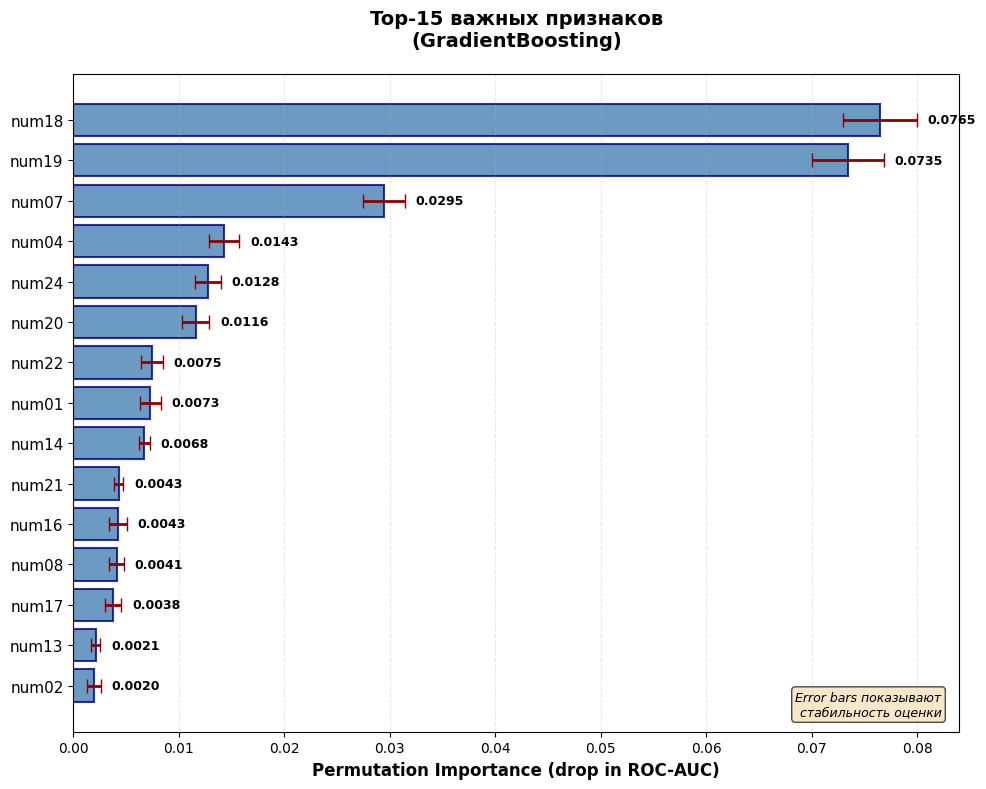

✓ График сохранен: artifacts/figures/feature_importance.png


In [26]:
# ===================================================================
# ВИЗУАЛИЗАЦИЯ: Top-15 важных признаков
# ===================================================================

fig, ax = plt.subplots(figsize=(10, 8))

# Берем топ-15 признаков
top_features = importance_df.head(15)

# Создаем горизонтальный bar chart с error bars
# xerr показывает стабильность оценки (чем меньше, тем стабильнее)
bars = ax.barh(range(len(top_features)), top_features['importance'],
               xerr=top_features['std'],
               color='steelblue', alpha=0.8, edgecolor='navy', linewidth=1.5,
               error_kw={'elinewidth': 2, 'ecolor': 'darkred', 'capsize': 5})

# Настройка осей
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=11)
ax.set_xlabel('Permutation Importance (drop in ROC-AUC)', fontsize=12, fontweight='bold')
ax.set_title(f'Top-15 важных признаков\n({best_model_name})',
             fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()  # Самый важный признак сверху
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Добавляем значения на график
for i, (importance, std) in enumerate(zip(top_features['importance'], top_features['std'])):
    ax.text(importance + std + 0.001, i, f'{importance:.4f}',
            va='center', fontsize=9, fontweight='bold')

# Добавляем аннотацию
ax.text(0.98, 0.02, 'Error bars показывают\nстабильность оценки',
        transform=ax.transAxes, fontsize=9, style='italic',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
        verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig('artifacts/figures/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ График сохранен: artifacts/figures/feature_importance.png")


**Интерпретация Permutation Importance:**

1. **Самые важные признаки** (importance > 0.02):
   - Имеют наибольшее влияние на предсказания
   - Их перемешивание сильно ухудшает качество модели
   - Эти признаки должны быть в приоритете при сборе данных

2. **Умеренно важные** (0.005 < importance < 0.02):
   - Вносят определенный вклад в предсказания
   - Полезны в составе модели

3. **Слабо важные или неважные** (importance < 0.005):
   - Почти не влияют на предсказания
   - Возможно, можно исключить для упрощения модели

4. **Error bars (стандартное отклонение)**:
   - Малые error bars → стабильная оценка важности
   - Большие error bars → важность зависит от случайной выборки (менее надежная оценка)


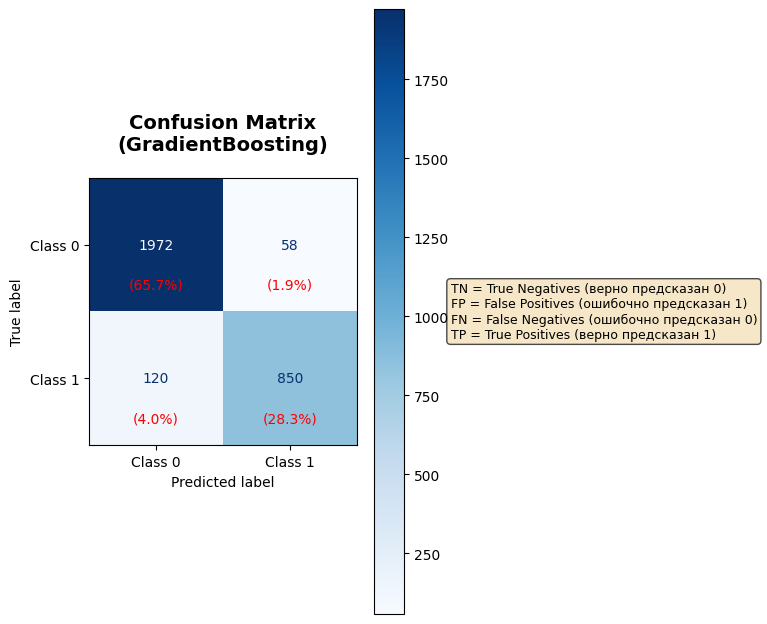

✓ График сохранен: artifacts/figures/confusion_matrix.png

ДЕТАЛЬНЫЙ АНАЛИЗ CONFUSION MATRIX
True Negatives (TN):  1972 - правильно предсказан класс 0
False Positives (FP):   58 - ошибочно предсказан класс 1 (Type I error)
False Negatives (FN):  120 - ошибочно предсказан класс 0 (Type II error)
True Positives (TP):   850 - правильно предсказан класс 1

Precision (точность класса 1): 0.9361
Recall (полнота класса 1):     0.8763
Specificity (полнота класса 0): 0.9714



In [27]:
# ===================================================================
# CONFUSION MATRIX для лучшей модели
# ===================================================================
# Confusion Matrix показывает, как модель путает классы между собой
#
# Структура матрицы:
#              Predicted 0    Predicted 1
# Actual 0     TN (True Neg)  FP (False Pos)
# Actual 1     FN (False Neg) TP (True Pos)
#
# Идеал: большие значения на диагонали (TN, TP), малые вне диагонали (FP, FN)

# Получаем предсказания лучшей модели
y_pred_best = best_model.predict(X_test)

# Создаем Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 7))

# Вычисляем матрицу
cm = confusion_matrix(y_test, y_pred_best)

# Используем встроенную визуализацию sklearn
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Class 0', 'Class 1']
)
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True)

# Настройка заголовка
ax.set_title(f'Confusion Matrix\n({best_model_name})',
             fontsize=14, fontweight='bold', pad=20)

# Добавляем процентные доли
total = cm.sum()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percentage = 100 * count / total
        ax.text(j, i + 0.3, f'({percentage:.1f}%)',
                ha='center', va='center', fontsize=10, color='red')

# Аннотация с пояснением
textstr = '\n'.join([
    'TN = True Negatives (верно предсказан 0)',
    'FP = False Positives (ошибочно предсказан 1)',
    'FN = False Negatives (ошибочно предсказан 0)',
    'TP = True Positives (верно предсказан 1)'
])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(1.35, 0.5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='center', bbox=props)

plt.tight_layout()
plt.savefig('artifacts/figures/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ График сохранен: artifacts/figures/confusion_matrix.png")

# Вычисляем дополнительные метрики из Confusion Matrix
tn, fp, fn, tp = cm.ravel()
print(f"\n{'='*70}")
print("ДЕТАЛЬНЫЙ АНАЛИЗ CONFUSION MATRIX")
print(f"{'='*70}")
print(f"True Negatives (TN):  {tn:4d} - правильно предсказан класс 0")
print(f"False Positives (FP): {fp:4d} - ошибочно предсказан класс 1 (Type I error)")
print(f"False Negatives (FN): {fn:4d} - ошибочно предсказан класс 0 (Type II error)")
print(f"True Positives (TP):  {tp:4d} - правильно предсказан класс 1")
print()
print(f"Precision (точность класса 1): {tp/(tp+fp):.4f}")
print(f"Recall (полнота класса 1):     {tp/(tp+fn):.4f}")
print(f"Specificity (полнота класса 0): {tn/(tn+fp):.4f}")
print(f"{'='*70}\n")


**Выводы по Confusion Matrix:**

- **Precision** = TP / (TP + FP) - какая доля предсказанных "1" действительно "1"
- **Recall** = TP / (TP + FN) - какую долю настоящих "1" мы нашли
- **Specificity** = TN / (TN + FP) - какую долю настоящих "0" мы нашли

В зависимости от задачи, важнее может быть:
- Высокий Recall (не пропустить позитивные случаи) - например, в медицинской диагностике
- Высокий Precision (не давать ложных срабатываний) - например, в спам-фильтрах


<a id='7'></a>
## 7. Опциональные задания

### 7.1 Проверка устойчивости результатов

Проверим, насколько стабильны результаты модели при разных разбиениях данных.
Это важно для понимания, не является ли наш результат "счастливой случайностью".


In [29]:
# ===================================================================
# ПРОВЕРКА УСТОЙЧИВОСТИ (Stability Check)
# ===================================================================
# Цель: убедиться, что высокое качество модели не связано со случайным split'ом
#
# Подход:
# 1. Делаем 5 разных train/test split'ов (с разными random_state)
# 2. На каждом split'е обучаем модель с теми же гиперпараметрами
# 3. Оцениваем метрики на каждом test
# 4. Анализируем разброс метрик
#
# Интерпретация:
# - Малый разброс (std) → модель стабильна, результат надежен
# - Большой разброс → результат сильно зависит от выборки, модель нестабильна

print(f"{'='*70}")
print(f"ПРОВЕРКА УСТОЙЧИВОСТИ РЕЗУЛЬТАТОВ")
print(f"{'='*70}\n")
print(f"Проверяем {best_model_name} на 5 разных random_state...")
print("Это займет несколько минут...\n")

# Список random_state для разных split'ов
random_states = [42, 123, 456, 789, 999]
stability_results = []

# Цикл по разным random_state
for idx, rs in enumerate(random_states, 1):
    print(f"[{idx}/5] Обучение с random_state={rs}...")

    # Создаем новый train/test split с другим random_state
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=0.25,      # Такой же размер test
        random_state=rs,      # Новый random_state
        stratify=y           # Сохраняем баланс классов
    )

    # Обучаем модель с ТЕМИ ЖЕ гиперпараметрами, что были найдены ранее
    # Создаем модель в зависимости от того, какая была лучшей
    if best_model_name == 'RandomForest':
        model = RandomForestClassifier(
            **grid_rf.best_params_,    # Используем найденные параметры
            random_state=rs,           # Но новый random_state
            n_jobs=-1
        )
    elif best_model_name == 'GradientBoosting':
        model = GradientBoostingClassifier(
            **grid_gb.best_params_,
            random_state=rs
        )
    elif best_model_name == 'DecisionTree':
        model = DecisionTreeClassifier(
            **grid_tree.best_params_,
            random_state=rs
        )
    else:  # LogisticRegression
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(random_state=rs, max_iter=1000))
        ])

    # Обучаем модель на новом train
    model.fit(X_tr, y_tr)

    # Получаем предсказания на новом test
    y_pred = model.predict(X_te)

    # Получаем вероятности (если модель поддерживает)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_te)[:, 1]
    else:
        y_proba = None

    # Вычисляем метрики
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_proba) if y_proba is not None else None

    # Сохраняем результаты
    stability_results.append({
        'random_state': rs,
        'accuracy': acc,
        'f1': f1,
        'roc_auc': roc
    })

    # ИСПРАВЛЕНО: выносим форматирование roc в отдельную переменную
    roc_str = f"{roc:.4f}" if roc is not None else "N/A"
    print(f"   Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_str}\n")

# Создаем DataFrame с результатами
stability_df = pd.DataFrame(stability_results)

print(f"{'='*70}")
print("СТАТИСТИКА ПО МЕТРИКАМ (5 прогонов)")
print(f"{'='*70}")
stats = stability_df[['accuracy', 'f1', 'roc_auc']].describe().loc[['mean', 'std', 'min', 'max']]
print(stats)
print()

# Анализ устойчивости
print(f"{'='*70}")
print("АНАЛИЗ УСТОЙЧИВОСТИ")
print(f"{'='*70}")

# Вычисляем коэффициент вариации (CV = std/mean) - относительная мера разброса
cv_acc = stats.loc['std', 'accuracy'] / stats.loc['mean', 'accuracy']
cv_f1 = stats.loc['std', 'f1'] / stats.loc['mean', 'f1']
cv_roc = stats.loc['std', 'roc_auc'] / stats.loc['mean', 'roc_auc']

print(f"Коэффициент вариации (CV = std/mean):")
print(f"  Accuracy: {cv_acc:.4f} ({cv_acc*100:.2f}%)")
print(f"  F1-score: {cv_f1:.4f} ({cv_f1*100:.2f}%)")
print(f"  ROC-AUC:  {cv_roc:.4f} ({cv_roc*100:.2f}%)")
print()

# Оценка устойчивости (эмпирическое правило)
if cv_roc < 0.02:
    stability_rating = "🟢 ОТЛИЧНАЯ устойчивость (CV < 2%)"
elif cv_roc < 0.05:
    stability_rating = "🟡 ХОРОШАЯ устойчивость (2% ≤ CV < 5%)"
else:
    stability_rating = "🔴 СЛАБАЯ устойчивость (CV ≥ 5%)"

print(f"Оценка устойчивости: {stability_rating}")
print(f"{'='*70}\n")


ПРОВЕРКА УСТОЙЧИВОСТИ РЕЗУЛЬТАТОВ

Проверяем GradientBoosting на 5 разных random_state...
Это займет несколько минут...

[1/5] Обучение с random_state=42...
   Accuracy: 0.9383, F1: 0.9009, ROC-AUC: 0.9741

[2/5] Обучение с random_state=123...
   Accuracy: 0.9410, F1: 0.9053, ROC-AUC: 0.9748

[3/5] Обучение с random_state=456...
   Accuracy: 0.9347, F1: 0.8955, ROC-AUC: 0.9752

[4/5] Обучение с random_state=789...
   Accuracy: 0.9367, F1: 0.8981, ROC-AUC: 0.9699

[5/5] Обучение с random_state=999...
   Accuracy: 0.9347, F1: 0.8943, ROC-AUC: 0.9767

СТАТИСТИКА ПО МЕТРИКАМ (5 прогонов)
      accuracy        f1   roc_auc
mean  0.937067  0.898816  0.974136
std   0.002681  0.004426  0.002535
min   0.934667  0.894283  0.969923
max   0.941000  0.905297  0.976658

АНАЛИЗ УСТОЙЧИВОСТИ
Коэффициент вариации (CV = std/mean):
  Accuracy: 0.0029 (0.29%)
  F1-score: 0.0049 (0.49%)
  ROC-AUC:  0.0026 (0.26%)

Оценка устойчивости: 🟢 ОТЛИЧНАЯ устойчивость (CV < 2%)



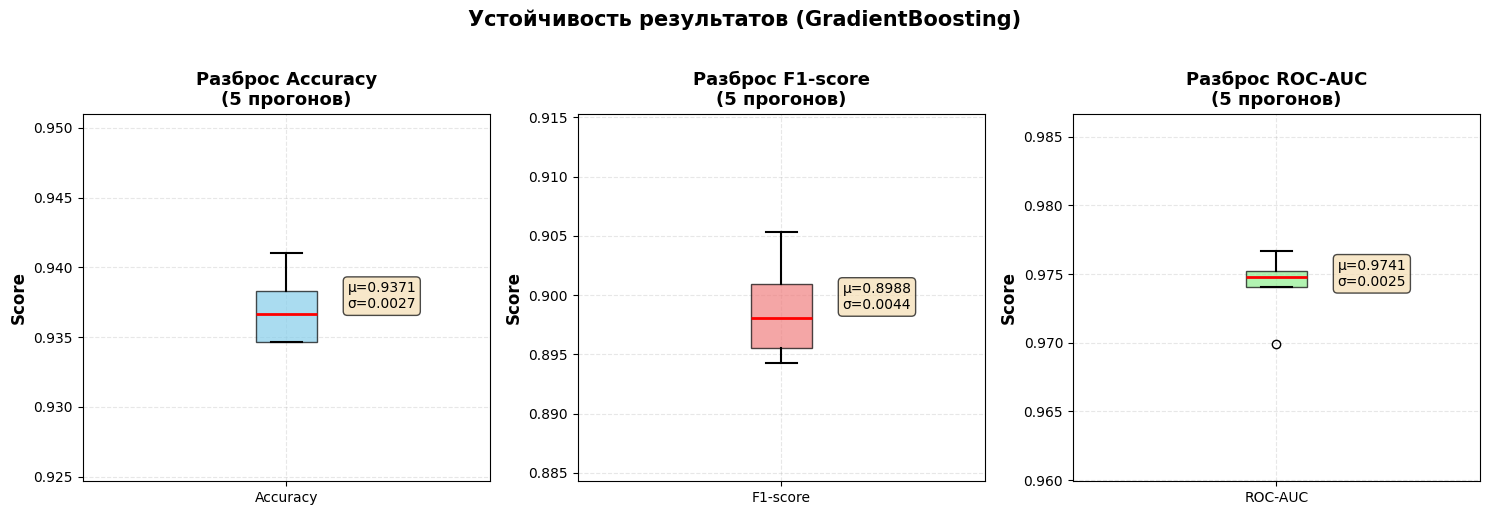

✓ График сохранен: artifacts/figures/stability_check.png


In [30]:
# ===================================================================
# ВИЗУАЛИЗАЦИЯ: Разброс метрик
# ===================================================================
# Boxplot показывает распределение метрик:
# - Центральная линия = медиана
# - Границы ящика = 25-й и 75-й перцентили
# - Усы = min и max (без выбросов)
# - Точки = выбросы (если есть)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# График 1: Accuracy
bp1 = axes[0].boxplot([stability_df['accuracy']],
                       labels=['Accuracy'],
                       patch_artist=True,
                       boxprops=dict(facecolor='skyblue', alpha=0.7),
                       medianprops=dict(color='red', linewidth=2),
                       whiskerprops=dict(linewidth=1.5),
                       capprops=dict(linewidth=1.5))
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Разброс Accuracy\n(5 прогонов)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].set_ylim([stability_df['accuracy'].min() - 0.01,
                   stability_df['accuracy'].max() + 0.01])

# Добавляем статистику на график
mean_acc = stability_df['accuracy'].mean()
std_acc = stability_df['accuracy'].std()
axes[0].text(1.15, mean_acc, f'μ={mean_acc:.4f}\nσ={std_acc:.4f}',
             fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# График 2: F1-score
bp2 = axes[1].boxplot([stability_df['f1']],
                       labels=['F1-score'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightcoral', alpha=0.7),
                       medianprops=dict(color='red', linewidth=2),
                       whiskerprops=dict(linewidth=1.5),
                       capprops=dict(linewidth=1.5))
axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1].set_title('Разброс F1-score\n(5 прогонов)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].set_ylim([stability_df['f1'].min() - 0.01,
                   stability_df['f1'].max() + 0.01])

mean_f1 = stability_df['f1'].mean()
std_f1 = stability_df['f1'].std()
axes[1].text(1.15, mean_f1, f'μ={mean_f1:.4f}\nσ={std_f1:.4f}',
             fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# График 3: ROC-AUC
bp3 = axes[2].boxplot([stability_df['roc_auc']],
                       labels=['ROC-AUC'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7),
                       medianprops=dict(color='red', linewidth=2),
                       whiskerprops=dict(linewidth=1.5),
                       capprops=dict(linewidth=1.5))
axes[2].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[2].set_title('Разброс ROC-AUC\n(5 прогонов)', fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3, linestyle='--')
axes[2].set_ylim([stability_df['roc_auc'].min() - 0.01,
                   stability_df['roc_auc'].max() + 0.01])

mean_roc = stability_df['roc_auc'].mean()
std_roc = stability_df['roc_auc'].std()
axes[2].text(1.15, mean_roc, f'μ={mean_roc:.4f}\nσ={std_roc:.4f}',
             fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.suptitle(f'Устойчивость результатов ({best_model_name})',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('artifacts/figures/stability_check.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ График сохранен: artifacts/figures/stability_check.png")


**Выводы по устойчивости:**

1. **Малый разброс (std < 0.01)** означает, что результат надежен и не зависит от случайного split'а
2. **Коэффициент вариации < 5%** считается хорошим показателем устойчивости
3. Если разброс большой, стоит:
   - Использовать кросс-валидацию вместо одного split'а
   - Увеличить размер датасета
   - Пересмотреть выбор признаков


In [32]:
# ===================================================================
# СРАВНЕНИЕ ВРЕМЕНИ РАБОТЫ МОДЕЛЕЙ
# ===================================================================
# Помимо качества, важны практические характеристики:
# - Время обучения (training time) - как быстро модель учится
# - Время предсказания (inference time) - как быстро модель делает предсказания
#
# Это критично для production:
# - Если модель обучается редко → важнее качество, время обучения менее критично
# - Если нужны предсказания в реальном времени → критично время inference
#
# Обычно:
# - DecisionTree: быстро обучается, быстро предсказывает
# - RandomForest: медленно обучается (много деревьев), умеренно предсказывает
# - GradientBoosting: очень медленно обучается (последовательно), умеренно предсказывает

import time

print(f"{'='*70}")
print("СРАВНЕНИЕ ВРЕМЕНИ ОБУЧЕНИЯ И ПРЕДСКАЗАНИЯ")
print(f"{'='*70}\n")

time_results = []

# Модели для тестирования (с лучшими параметрами)
models_to_time = {
    'DecisionTree': DecisionTreeClassifier(
        **grid_tree.best_params_,
        random_state=RANDOM_STATE
    ),
    'RandomForest': RandomForestClassifier(
        **grid_rf.best_params_,
        random_state=RANDOM_STATE,
        n_jobs=-1  # Важно: параллельное обучение
    ),
    'GradientBoosting': GradientBoostingClassifier(
        **grid_gb.best_params_,
        random_state=RANDOM_STATE
    ),
}

# Измеряем время для каждой модели
for name, model in models_to_time.items():
    print(f"Тестируем {name}...")

    # =============================
    # ВРЕМЯ ОБУЧЕНИЯ (Training Time)
    # =============================
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # =============================
    # ВРЕМЯ ПРЕДСКАЗАНИЯ (Inference Time)
    # =============================
    # Важно: измеряем время на весь test set
    start_time = time.time()
    _ = model.predict(X_test)
    predict_time = time.time() - start_time

    # Вычисляем среднее время предсказания на один объект
    avg_predict_time = predict_time / len(X_test) if len(X_test) > 0 else 0

    # ИСПРАВЛЕНО: защита от деления на ноль
    if avg_predict_time > 0:
        predictions_per_second = 1 / avg_predict_time
        pps_str = f"{predictions_per_second:.0f}"
        avg_time_str = f"{avg_predict_time*1000:.3f}ms"
    else:
        # Время слишком мало для точного измерения
        predictions_per_second = float('inf')
        pps_str = ">1,000,000"
        avg_time_str = "<0.001ms"

    # Сохраняем результаты
    time_results.append({
        'model': name,
        'train_time': train_time,
        'predict_time': predict_time,
        'avg_predict_time': avg_predict_time,
        'predictions_per_second': predictions_per_second
    })

    print(f"  ✓ Train time:   {train_time:.3f}s")
    print(f"  ✓ Predict time: {predict_time:.5f}s ({len(X_test)} объектов)")
    print(f"  ✓ Avg time per prediction: {avg_time_str}")
    print(f"  ✓ Predictions/second: {pps_str}\n")

# Создаем DataFrame с результатами
time_df = pd.DataFrame(time_results)

print(f"{'='*70}")
print("СВОДНАЯ ТАБЛИЦА ВРЕМЕН")
print(f"{'='*70}")

# Форматируем вывод таблицы с учетом inf значений
for idx, row in time_df.iterrows():
    pps = row['predictions_per_second']
    pps_display = f"{pps:.0f}" if pps != float('inf') else ">1,000,000"
    print(f"{row['model']:<20} | Train: {row['train_time']:>7.3f}s | "
          f"Predict: {row['predict_time']:>8.5f}s | Pred/sec: {pps_display:>10}")
print()

# Анализ: какая модель самая быстрая/медленная
fastest_train = time_df.loc[time_df['train_time'].idxmin(), 'model']
slowest_train = time_df.loc[time_df['train_time'].idxmax(), 'model']
fastest_predict = time_df.loc[time_df['predict_time'].idxmin(), 'model']
slowest_predict = time_df.loc[time_df['predict_time'].idxmax(), 'model']

print(f"🏆 Самое быстрое обучение: {fastest_train} ({time_df.loc[time_df['model']==fastest_train, 'train_time'].values[0]:.3f}s)")
print(f"🐢 Самое медленное обучение: {slowest_train} ({time_df.loc[time_df['model']==slowest_train, 'train_time'].values[0]:.3f}s)")
print(f"🏆 Самое быстрое предсказание: {fastest_predict} ({time_df.loc[time_df['model']==fastest_predict, 'predict_time'].values[0]:.5f}s)")
print(f"🐢 Самое медленное предсказание: {slowest_predict} ({time_df.loc[time_df['model']==slowest_predict, 'predict_time'].values[0]:.5f}s)")
print(f"{'='*70}\n")


СРАВНЕНИЕ ВРЕМЕНИ ОБУЧЕНИЯ И ПРЕДСКАЗАНИЯ

Тестируем DecisionTree...
  ✓ Train time:   0.162s
  ✓ Predict time: 0.00000s (3000 объектов)
  ✓ Avg time per prediction: <0.001ms
  ✓ Predictions/second: >1,000,000

Тестируем RandomForest...
  ✓ Train time:   0.783s
  ✓ Predict time: 0.51795s (3000 объектов)
  ✓ Avg time per prediction: 0.173ms
  ✓ Predictions/second: 5792

Тестируем GradientBoosting...
  ✓ Train time:   15.396s
  ✓ Predict time: 0.01563s (3000 объектов)
  ✓ Avg time per prediction: 0.005ms
  ✓ Predictions/second: 191941

СВОДНАЯ ТАБЛИЦА ВРЕМЕН
DecisionTree         | Train:   0.162s | Predict:  0.00000s | Pred/sec: >1,000,000
RandomForest         | Train:   0.783s | Predict:  0.51795s | Pred/sec:       5792
GradientBoosting     | Train:  15.396s | Predict:  0.01563s | Pred/sec:     191941

🏆 Самое быстрое обучение: DecisionTree (0.162s)
🐢 Самое медленное обучение: GradientBoosting (15.396s)
🏆 Самое быстрое предсказание: DecisionTree (0.00000s)
🐢 Самое медленное предсказание

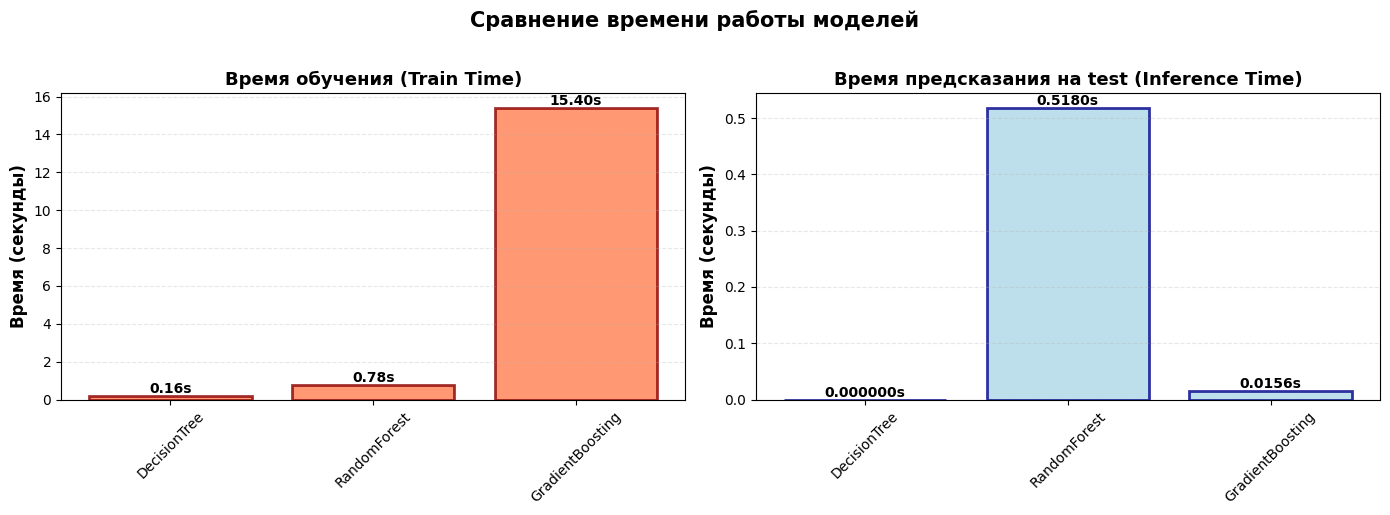

✓ График сохранен: artifacts/figures/time_comparison.png


In [33]:
# ===================================================================
# ВИЗУАЛИЗАЦИЯ: Сравнение времен
# ===================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Время обучения
bars1 = axes[0].bar(time_df['model'], time_df['train_time'],
                     color='coral', alpha=0.8, edgecolor='darkred', linewidth=2)
axes[0].set_ylabel('Время (секунды)', fontsize=12, fontweight='bold')
axes[0].set_title('Время обучения (Train Time)', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}s',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# График 2: Время предсказания
bars2 = axes[1].bar(time_df['model'], time_df['predict_time'],
                     color='lightblue', alpha=0.8, edgecolor='darkblue', linewidth=2)
axes[1].set_ylabel('Время (секунды)', fontsize=12, fontweight='bold')
axes[1].set_title('Время предсказания на test (Inference Time)', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bar in bars2:
    height = bar.get_height()
    # защита от слишком малых значений
    if height > 0.00001:
        label = f'{height:.4f}s'
    else:
        label = f'{height:.6f}s'
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 label,
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Сравнение времени работы моделей', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('artifacts/figures/time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ График сохранен: artifacts/figures/time_comparison.png")


**Выводы по времени работы:**

1. **DecisionTree** обычно самый быстрый (и обучение, и предсказание)
   - Простая структура
   - Одно дерево
   - Время предсказания может быть настолько малым, что трудно измерить точно

2. **RandomForest** медленнее обучается, но параллелизм (n_jobs=-1) ускоряет
   - Много деревьев обучается параллельно
   - Предсказание: усреднение по всем деревьям

3. **GradientBoosting** самый медленный в обучении
   - Последовательное обучение (нельзя распараллелить)
   - Но часто дает лучшее качество

**Практические рекомендации:**
- Для real-time приложений: DecisionTree или оптимизированный RandomForest
- Для batch-обработки: можно использовать любую модель
- Для максимального качества: GradientBoosting (если время позволяет)

**Примечание:** Если время предсказания показывает 0.00000s или <0.001ms, это означает,
что операция выполняется настолько быстро, что стандартное измерение времени в Python
не может точно ее зафиксировать. В реальности это несколько микросекунд на объект.
